In [2]:
# Library for hyper-parameter tuning
from keras_tuner import RandomSearch

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
import seaborn as sns
import tensorflow as tf
from tensorflow import keras


In [4]:
# Loading the data files and getting rid of unnecessary columns
df_hr = pd.read_excel('Data-hourly.xlsx').iloc[1:, :7]
df_d = pd.read_excel('Data-daily.xlsx').iloc[1:, :7]
df_w = pd.read_excel('Data-weekly.xlsx').iloc[1:, :7]
df_mon = pd.read_excel('Data-monthly.xlsx').iloc[1:, :7]
df_yr = pd.read_excel('Data-yearly.xlsx').iloc[1:, :7]
df_hr.rename(columns={'Unnamed: 0':'Time'}, inplace=True)
df_d.rename(columns={'Unnamed: 0':'Time'}, inplace=True)
df_w.rename(columns={'Unnamed: 0':'Time'}, inplace=True)
df_mon.rename(columns={'Unnamed: 0':'Time'}, inplace=True)
df_yr.rename(columns={'Unnamed: 0':'Time'}, inplace=True)
# Converting the float format to datetime format
df_yr['Time'] = pd.to_datetime(df_yr['Time'], format='%Y')
# Setting the "Time" column as the index
#df_hr = df_hr.set_index('Time')
#df_d = df_d.set_index('Time')
#df_w = df_w.set_index('Time')
#df_mon = df_mon.set_index('Time')
#df_yr = df_yr.set_index('Time')

In [6]:
# To check the general description/info of the dataset(s)
df_mon.describe()


,Open,High,Low,Close,Adj Close,Volume
count,48.000000,48.000000,48.000000,48.000000,48.000000,4.800000e+01
mean,59.195417,64.437031,55.703490,60.908593,59.329863,2.698038e+09
std,26.942680,30.653924,24.951097,28.224774,28.442523,8.041180e+08
min,31.757500,34.369999,31.752501,34.247501,32.148296,1.493216e+09
25%,41.720001,44.239999,39.646876,41.923125,40.168502,2.158885e+09
50%,48.846250,52.973749,45.518749,48.526249,47.232014,2.641497e+09
75%,67.755623,74.224375,62.735626,69.608121,68.401516,2.973190e+09
max,133.520004,145.089996,126.379997,132.690002,131.515961,6.280072e+09


In [ ]:
# Checking the number of Nan values: There is no Nan entry (in any of the time-frames)
print('Hourly:\n',df_hr.isna().sum())
print('Daily:\n', df_d.isna().sum())
print('Weekily:\n', df_w.isna().sum())
print('Monthly:\n', df_mon.isna().sum())
print('Yearly:\n', df_yr.isna().sum())

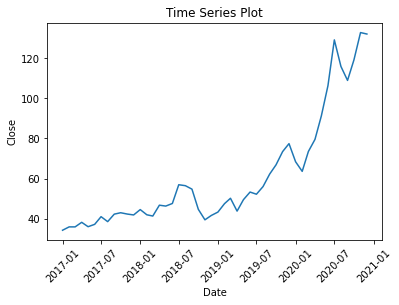

In [15]:
# EDA on the yearly time-frame
plt.plot(df_mon['Time'], df_mon['Close'] )

# Labelling 
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Time Series Plot")
plt.xticks(rotation = 45)
# Display

plt.show()

In [19]:
# Hypothesis Testing: Stationary test
# The test shows that the data for all the time-frames is non-stationary, except for the yearly time-frame, which is stationary
from statsmodels.tsa.stattools import kpss
data = df_mon['Close']
stat, p, lags, crit = kpss(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Stationary')
else:
    print('Probably not Stationary')

stat=0.492, p=0.043
Probably not Stationary


In [5]:
# Data preparation
forecast_size = 15
category = 3
train_percentage = 0.8
CNN = 1 # choice of model: MLP=0, CNN=1

df = df_mon # choice of time_frame: df_hr, df_d, df_w, df_mon, df_yr
keys = [i for i in df]
data = df.to_numpy()[1:]
years = [data[i][0].year for i in range(data.shape[0])]
months = [data[i][0].month for i in range(data.shape[0])]
days = [data[i][0].day for i in range(data.shape[0])]
hours = [data[i][0].hour for i in range(data.shape[0])]
monthly, daily, hourly, yearly, weekly = 0, 0, 0, 0, 0
if data[1][0].day-data[0][0].day == 7:
    weekly = 1
    period = 7

if weekly == 0 and np.unique(days).shape[0] > 1:
    daily = 1
    period = 30

if weekly+daily == 0 and np.unique(months).shape[0] > 1:
    monthly = 1
    period = 12
    
if np.unique(hours).shape[0] > 1:
    hourly = 1
    period = 24

if hourly+daily+weekly+monthly == 0 and np.unique(years).shape[0] > 1:
    yearly = 1
    period = 5
date = data[0,0]
data = np.float32(data[:,category])
data[np.isnan(data)] = 0
data[data==0] = 2**-15
normalize = 1
for i in range(16):
    if abs(np.max(data) - 2**i) < abs(np.max(data) - normalize):
        normalize = 2**i

data = data / normalize
    
    
    
x = []
y = []
for i in range(data.shape[0]-period):        
    x.append([data[i+j] for j in range(period)])
    y.append([data[i+period]])

x = np.array(x)
y = np.array(y)
train_size = int(x.shape[0] * train_percentage)

x_train = x[:train_size]
y_train = y[:train_size]
if CNN==1:
    x.shape = (1,)+ x.shape
    y.shape = (1,)+ y.shape
    x_train.shape = (1,)+ x_train.shape
    y_train.shape = (1,)+ y_train.shape


In [6]:
# Models
# MLP Model(ReLU)
# Defining the model
n_nodes = 10
n_input = period
model_mlp_relu = keras.models.Sequential()
model_mlp_relu.add(keras.layers.Dense(n_nodes, activation='relu', input_dim=n_input))
model_mlp_relu.add(keras.layers.Dense(1))
model_mlp_relu.compile(loss='mse', optimizer='adam')

# MLP Model(PReLU)
# Defining the model
model_mlp_prelu = keras.models.Sequential()
model_mlp_prelu.add(keras.layers.Dense(n_nodes, input_dim=n_input))
model_mlp_prelu.add(keras.layers.PReLU())
model_mlp_prelu.add(keras.layers.Dense(1))
model_mlp_prelu.compile(loss='mse', optimizer='adam')

# CNN Model
# Defining the model
model_cnn = keras.Sequential([
keras.layers.InputLayer((None, period)),
keras.layers.Conv1D(128, 3, strides=1, padding='same', activation='elu'),
keras.layers.Conv1D(128, 3, strides=1, padding='same', activation='elu'),
keras.layers.Conv1D(128, 3, strides=1, padding='same', activation='elu'),
keras.layers.Conv1D(128, 3, strides=1, padding='same', activation='elu'),
keras.layers.Conv1D(1, 1, strides=1, padding='same')
])


In [180]:
tf.random.set_seed(0)
k = keras.backend
def mape2(y_true, y_pred):
    er_train = keras.losses.mape(y_true, y_pred)
    er_test = keras.losses.mape(y_true[:,train_size:], y_pred[:,train_size:])
    er = (k.mean(er_train, axis=-1, keepdims=True) + k.mean(er_test, axis=-1, keepdims=True)) * 0.5
    return er

# Fitting the model 
model = model_cnn
model.compile(optimizer='adam', loss='mse', metrics=['mape', mape2])
model.summary()
history = model.fit(x_train, y_train, epochs=1000, validation_data=(x, y), 
          callbacks=[keras.callbacks.EarlyStopping(
                monitor='val_mape2', patience=4000,
                mode='min', restore_best_weights=True) ])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, None, 128)         4736      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, None, 1)           129       
Total params: 152,705
Trainable params: 152,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

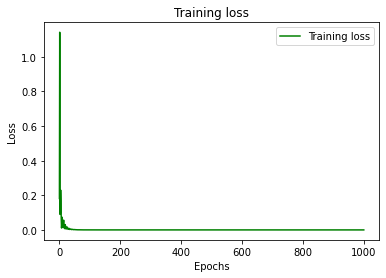

In [181]:
loss_train = history.history['loss']

epochs = range(0,1000)
plt.plot(epochs, loss_train, 'g', label='Training loss')
#plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [182]:
# Statistical measures on training and test data

mape_tr = np.mean(np.abs(model.predict(x_train) - y_train) / np.abs(y_train)) * 100
rmse_tr = np.sqrt(np.mean(np.square(model.predict(x_train) - y_train)))
mae_tr = np.mean(np.abs(model.predict(x_train) - y_train)) 
r2_tr = 1- (np.sum(np.square(model.predict(x_train) - y_train)))/(np.sum(np.square(np.mean(y_train) - y_train)))
print('train MAPE: ' + str(mape_tr) +'%'+ '\n')
print('train RMSE:' + str(rmse_tr)+'\n')
print('train MAE:' + str(mae_tr)+'\n')
print('train R2:' + str(r2_tr)+'\n')

p = model.predict(x)
if p.shape[0] == 1:
    mape_ts = np.mean(np.abs(p[:,train_size:] - y[:,train_size:]) / np.abs(y[:,train_size:])) * 100
    rmse_ts = np.sqrt(np.mean(np.square(p[:,train_size:] - y[:,train_size:])))
    mae_ts = np.mean(np.abs(p[:,train_size:] - y[:,train_size:])) 
    r2_ts = 1- (np.sum(np.square(p[:,train_size:] - y[:,train_size:])))/(np.sum(np.square(np.mean(y[:,train_size:]) - y[:,train_size:])))

else:
    mape_ts = np.mean(np.abs(p[train_size:] - y[train_size:]) / np.abs(y[train_size:])) * 100
    rmse_ts = np.sqrt(np.mean(np.square(p[train_size:] - y[train_size:])))
    mae_ts = np.mean(np.abs(p[train_size:] - y[train_size:]))
    r2_ts = 1- (np.sum(np.square(p[train_size:] - y[train_size:])))/(np.sum(np.square(np.mean(y[train_size:]) - y[train_size:])))


print('test MAPE: ' + str(mape_ts) +'%'+ '\n')
print('test RMSE:' + str(rmse_ts)+'\n')
print('test MAE:' + str(mae_ts)+'\n')
print('test R2:' + str(r2_ts)+'\n')

train MAPE: 0.2755753695964813%

train RMSE:0.0013928737

train MAE:0.0009939319

train R2:0.9997435957193375

test MAPE: 9.945183992385864%

test RMSE:0.10543663

test MAE:0.08886438

test R2:-0.4864853620529175



In [183]:
# Generating forecasted data (future)
date_1 = date
o = x.copy()
shape = o.shape[0]
if shape == 1:
    shape = o.shape[1]
for i in range(shape, shape+forecast_size+1):
    p = model.predict(o)
    if o.shape[0] > 1:
        ap = np.append(o[-1:,1:], p[-1:], axis=-1)
    else:
        ap = np.append(o[:,-1:,1:], p[:,-1:], axis=-1)
    o = np.append(o, ap, axis=-2)

if o.shape[0] == 1: o = o[0]
oo = []
pad = [[i] for i in data[:period-1]]
for j in [pad, o]:
    for i in j:
        oo.append([date_1, i[-1]*normalize])
        if hourly == 1:
            date_1 = date_1 + pd.offsets.DateOffset(hours=1)
        elif daily == 1:
            date_1 = date_1 + pd.offsets.DateOffset(days=1)
        elif weekly ==1:
            date_1 = date_1 + pd.offsets.DateOffset(days=7)    
        elif monthly == 1:
            date_1 = date_1 + pd.offsets.DateOffset(months=1)
        elif yearly == 1:
            date_1 = date_1 + pd.offsets.DateOffset(years=1)

    

df_1 = pd.DataFrame(oo)
df_1.columns = ['date', keys[category]]
pd.set_option("display.max_rows", None, "display.max_columns", None)
print('forecasted data:')
print(df_1)
df_1.to_excel('forecast.xls', index=False)


forecasted data:
         date         Low
0  2017-02-01   34.262501
1  2017-03-01   35.014999
2  2017-04-01   36.067501
3  2017-05-01   35.549999
4  2017-06-01   35.602501
5  2017-07-01   37.102501
6  2017-08-01   37.290001
7  2017-09-01   38.115002
8  2017-10-01   41.320000
9  2017-11-01   41.615002
10 2017-12-01   41.174999
11 2018-01-01   37.560001
12 2018-02-01   41.235001
13 2018-03-01   40.157501
14 2018-04-01   41.317501
15 2018-05-01   45.182499
16 2018-06-01   45.855000
17 2018-07-01   49.327499
18 2018-08-01   53.825001
19 2018-09-01   51.522499
20 2018-10-01   42.564999
21 2018-11-01   36.647499
22 2018-12-01   35.500000
23 2019-01-01   41.482498
24 2019-02-01   42.375000
25 2019-03-01   47.095001
26 2019-04-01   43.747501
27 2019-05-01   42.567501
28 2019-06-01   49.602501
29 2019-07-01   48.145000
30 2019-08-01   51.055000
31 2019-09-01   53.782501
32 2019-10-01   62.290001
33 2019-11-01   64.072502
34 2019-12-01   73.187500
35 2020-01-01   64.092499
36 2020-02-01   53.15

<ipython-input-183-a5592e46ff27>:39: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df_1.to_excel('forecast.xls', index=False)


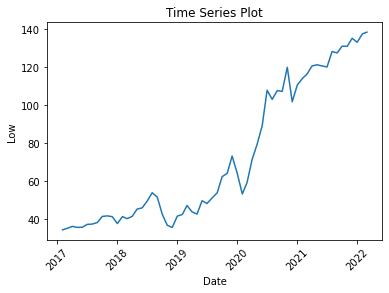

In [184]:
plt.plot(df_1['date'], df_1['Low'] )

# Labelling 
plt.xlabel("Date")
plt.ylabel("Low")
plt.title("Time Series Plot")
plt.xticks(rotation = 45)
# Display

plt.show()

In [7]:
# Hyper-parameter tuning
# Defining the tuner
def model_builder(hp):
    model = keras.Sequential()
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model
tuner = RandomSearch(model_builder, objective='val_accuracy', max_trials = 4, overwrite = True)

In [8]:
# Running the tuner
tuner.search(x, y, epochs=50, validation_split=0.2)

Trial 4 Complete [00h 00m 01s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 00m 08s
INFO:tensorflow:Oracle triggered exit
